In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [20]:
data = pd.read_csv('./../data/clean/races_info_features.csv', index_col='race')
data.head()

,racename,date,imlink,city,image_url,logo_url,region,images,country_code,lat,...,swim_min,swim_mean,swim_max,bike_min,bike_mean,bike_max,run_min,run_mean,run_max,is_70.3
race,,,,,,,,,,,,,,,,,,,,,
alagoas70.3,IRONMAN 70.3 Maceió,2019-08-04,http://www.ironman.com/triathlon/events/americ...,"Maceió, Alagoas Brazil",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,South America,races_images_v9/alagoas70.3/df3f89f01e6d1986ac...,BRA,-9.661669,...,1448.000000,2288.078225,4201.000000,6720.000000,9560.845075,14475.500000,4791.500000,7484.210043,15817.000000,True
arizona,IRONMAN Arizona,2019-11-24,http://www.ironman.com/triathlon/events/americ...,"Tempe, AZ",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/arizona/36fe28a1b3f195822ca9ca...,USA,33.433518,...,2866.928571,4929.300964,8357.928571,15552.928571,22732.497606,30975.857143,9291.571429,18506.510752,31598.642857,False
Arizona70.3,IRONMAN 70.3 Arizona,2019-10-20,http://www.ironman.com/triathlon/events/americ...,"Tempe, Arizona",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/Arizona70.3/0e732e7b0440b1e0b6...,USA,33.432270,...,1510.000000,2693.761513,4772.500000,8100.250000,11175.956754,16604.000000,4942.750000,9215.025924,16576.250000,True
astana70.3,IRONMAN 70.3 Astana,2019-07-14,http://www.ironman.com/triathlon/events/emea/i...,"Astana, Kazakhstan",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,Middle East,races_images_v9/astana70.3/39f3900e33333f7a6ce...,KAZ,51.125358,...,1462.000000,2542.563966,4768.000000,7721.000000,10664.704691,15261.000000,4713.000000,7369.575693,13246.000000,True
atlanticcity70.3,IRONMAN 70.3 Atlantic City,2019-09-15,http://www.ironman.com/triathlon/events/americ...,"Atlantic City, New Jersey",https://s3-us-west-2.amazonaws.com/obstri/race...,https://s3-us-west-2.amazonaws.com/obstri/race...,North America,races_images_v9/atlanticcity70.3/77259529bebd1...,USA,39.350119,...,1312.000000,2438.714203,4572.000000,7813.666667,10913.723092,17382.666667,4652.333333,8477.862647,14797.000000,True


# Naive KNN with all features

In [111]:
def get_column_names_from_ColumnTransformer(column_transformer, hasModel=True):    
    col_name = []
    if hasModel:
        #the last transformer is ColumnTransformer's 'remainder'
        transformers_to_go_through = column_transformer.transformers_[:-1]
    else:
        transformers_to_go_through = column_transformer.transformers_
    for transformer_in_columns in transformers_to_go_through:
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [160]:
data[cols_selection].columns

Index(['n_years_existance', 'entrants_count_avg', 'run_sinusoity',
       'run_distance', 'run_elevationGain', 'run_score', 'bike_sinusoity',
       'bike_distance', 'bike_elevationGain', 'bike_score', 'swim_distance',
       'attractivity_score', 'perc_entrants_from_country', 'perc_female',
       'wc_slots', 'distance_to_nearest_shoreline',
       'distance_to_nearest_airport',
       'distance_to_nearest_airport_international', 'n_metropolitan_cities',
       'n_hotels', 'n_restaurants', 'n_entertainment', 'n_nightlife',
       'n_shops', 'n_bike_shops', 'n_pools', 'n_athletic_centers',
       'n_fitness_centers', 'temperatureMin', 'temperatureMax',
       'apparentTemperatureMin', 'apparentTemperatureMax', 'swim_min',
       'swim_mean', 'swim_max', 'bike_min', 'bike_mean', 'bike_max', 'run_min',
       'run_mean', 'run_max', 'region', 'country_code', 'swim_type',
       'ironkids_race', 'is_70.3'],
      dtype='object')

In [112]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = [
    'n_years_existance', 'entrants_count_avg', 'run_sinusoity', 'run_distance',
    'run_elevationGain', 'run_score', 'bike_sinusoity', 'bike_distance',
    'bike_elevationGain', 'bike_score', 'swim_distance', 'attractivity_score',
    'perc_entrants_from_country', 'perc_female', 'wc_slots', 'distance_to_nearest_shoreline',
    'distance_to_nearest_airport', 'distance_to_nearest_airport_international',
    'n_metropolitan_cities', 'n_hotels', 'n_restaurants', 'n_entertainment', 'n_nightlife',
    'n_shops', 'n_bike_shops', 'n_pools', 'n_athletic_centers', 'n_fitness_centers',
    'temperatureMin', 'temperatureMax', 'apparentTemperatureMin', 'apparentTemperatureMax',
    'swim_min', 'swim_mean', 'swim_max', 'bike_min', 'bike_mean', 'bike_max', 'run_min',
    'run_mean', 'run_max',
]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [
    'region', 'country_code', 'swim_type', 'ironkids_race',  'is_70.3'
]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

cols_selection = numeric_features+categorical_features

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
fullModel = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5))])
# somehow cannot access the methods of NearestNeighbors from pipeline.
# so have to run the preprocessor steps and model separately

In [116]:
# run the data through the preprocessor
X = data.loc[:, cols_selection]
X_transformed = preprocessor.fit_transform(X)

# get df of transformed features
cols_transformed = get_column_names_from_ColumnTransformer(preprocessor, hasModel=False)
data_transformed = pd.DataFrame(X_transformed, columns=cols_transformed, index=data.index)

# Model and fit on processed data
model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)
model.fit(X_transformed)


query = 'france70.3'
distances, indices = model.kneighbors(data_transformed.loc[query].values.reshape(1, -1), n_neighbors=10)

pd.concat([pd.Series(data.iloc[indices.flatten()].index), pd.DataFrame(distances).transpose()], axis=1)

,race,0
0,france70.3,0.000000
1,salzburg70.3,0.198911
2,gdynia70.3,0.368425
3,edinburgh70.3,0.381255
4,luxembourg70.3,0.383427
5,switzerland70.3,0.412031
6,lakeplacid70.3,0.444978
7,pula70.3,0.461414
8,kraichgau70.3,0.463232
9,Haugesund70.3,0.471883


In [92]:
# this is similar than calculating the cosine_similarity

from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(X_transformed)
cos_sim_df = pd.DataFrame(cos_sim, index=data.index, columns=data.index)
cos_sim_df['france70.3'].sort_values(ascending=False).iloc[:10]

race
france70.3         1.000000
salzburg70.3       0.801089
gdynia70.3         0.631575
edinburgh70.3      0.618745
luxembourg70.3     0.616573
switzerland70.3    0.587969
lakeplacid70.3     0.555022
pula70.3           0.538586
kraichgau70.3      0.536768
Haugesund70.3      0.528117
Name: france70.3, dtype: float64

## Add weight after standardization?

In [140]:
data.distance_to_nearest_shoreline.sort_values(ascending=False)

race
astana70.3            1416.943720
boulder70.3           1215.265776
boulder               1208.491337
wisconsin             1088.497090
wisconsin70.3         1086.842887
steelhead70.3          870.210314
louisville             733.393872
buffalosprings70.3     719.121953
muncie70.3             708.377550
calgary70.3            651.321568
qujing70.3             582.186736
stgeorge70.3           550.996466
st.george              550.073912
ohio70.3               530.924461
chattanooga70.3        496.629313
chattanooga            496.382742
challengeroth          414.671462
coeurdalene70.3        406.975295
kraichgau70.3          384.604694
muskoka70.3            353.903295
germany                333.974443
switzerland            326.011382
austria70.3            311.159439
switzerland70.3        310.368531
vichy                  290.240496
vichy70.3              290.234311
monterrey70.3          289.631370
waco70.3               284.933933
liuzhou70.3            278.175230
Arizona70

In [156]:
# run the data through the preprocessor
X = data.loc[:, cols_selection]
X_transformed = preprocessor.fit_transform(X)

# get df of transformed features
cols_transformed = get_column_names_from_ColumnTransformer(preprocessor, hasModel=False)
data_transformed = pd.DataFrame(X_transformed, columns=cols_transformed, index=data.index)

# data_transformed[['distance_to_nearest_shoreline']] = 1/(10*data_transformed[['distance_to_nearest_shoreline']])
data_transformed[['wc_slots']] = 10*data_transformed[['wc_slots']]

# Model and fit on processed data
model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)
model.fit(data_transformed.values)


query = 'liuzhou70.3'
distances, indices = model.kneighbors(data_transformed.loc[query].values.reshape(1, -1), n_neighbors=10)

pd.concat([data.iloc[indices.flatten()][['distance_to_nearest_shoreline', 'wc_slots']], pd.DataFrame(distances.transpose(), index=data.iloc[indices.flatten()].index)], axis=1)

,distance_to_nearest_shoreline,wc_slots,0
race,,,
liuzhou70.3,278.175230,25.0,2.220446e-16
xiamen70.3,0.910548,30.0,7.808931e-02
westernaustralia,1.700359,65.0,2.250156e-01
mardelplata,0.793824,75.0,2.333850e-01
southafrica,1.722589,80.0,2.389637e-01
cairns,1.516762,80.0,2.460022e-01
vichy,290.240496,40.0,2.781227e-01
newzealand,101.103347,40.0,2.896513e-01
taiwan,1.100908,35.0,2.905951e-01


# Add SVD factorization to the pipeline

In [100]:
from sklearn.decomposition import TruncatedSVD

SVD = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', TruncatedSVD(n_components=10, random_state=17))])

X_factorized = SVD.fit_transform(X)

# Model and fit on processed data
model_svd = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)
model_svd.fit(X_factorized)

query = 'france70.3'
idx_query = data.index.tolist().index(query)
distances, indices = model_svd.kneighbors(X_factorized[idx_query].reshape(1, -1), n_neighbors=10)

pd.concat([pd.Series(data.iloc[indices.flatten()].index), pd.DataFrame(distances).transpose()], axis=1)

,race,0
0,france70.3,1.110223e-16
1,salzburg70.3,7.395978e-02
2,gdynia70.3,1.918248e-01
3,luxembourg70.3,2.002113e-01
4,switzerland70.3,2.068634e-01
5,edinburgh70.3,2.658061e-01
6,Haugesund70.3,2.719857e-01
7,DunLaoghaire70.3,2.797550e-01
8,victoria70.3,2.869063e-01
9,marbella70.3,3.060935e-01


# Races data

In [3]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM races;"
# execute the query and assign it to a pandas dataframe
df_races = pd.read_sql(query, con=cnx)

cnx.close()

print("Number of single races:", len(df_races))

Number of single races: 220


### Some processing on the datasets

In [4]:
# -----------
# -- RACES --
# -----------

# keep only active races
df_races = df_races.loc[df_races['info'].dropna().index]

# remove duplicates
df_races = df_races.loc[df_races.race != 'worldchampionship70.3m']

# remove worldchampionship as it's by qualification so people cannot really choose to do it
df_races = df_races.loc[df_races.race != 'worldchampionship70.3']
df_races = df_races.loc[df_races.race != 'worldchampionship']

# add Country codes
with open("./../data/geo-data/races_geo_info.json", 'r') as f:
    races_geo_info = json.loads(f.read())
             
df_races['country_code'] = None
for race in df_races.race.values:
    country_code = races_geo_info[race]
    df_races.loc[df_races.race == race, 'country_code'] = races_geo_info[race]['components']['ISO_3166-1_alpha-3']

# Add location info
races_locations = pd.read_csv("./../data/geo-data/races_lat_lon.csv")
df_races = df_races.merge(races_locations, left_on = 'race', right_on = 'race', how = 'left')

# Add info about type of race
# saving the races references for index
df_races['is_70.3'] = df_races['race'].str.contains('70.3')

# keep only columns of interest
df_races = df_races[['race', 'racename', 'is_70.3', 'region', 'country_code', 'lat', 'lon']]

# make the index the race name
df_races = df_races.set_index('race')

print("Number of single races:", len(df_races))

Number of single races: 157


In [5]:
# -----------
# -- RESULTS --
# -----------

# worldchampionship70.3 and worldchampionship70.3m are the same race
df_results.loc[df_results.race == "worldchampionship70.3m", 'race'] = 'worldchampionship70.3'

# keep only results of non discontinued races
df_results = df_results[df_results['race'].isin(df_races.index)]

# extract gender from division
df_results['gender'] = df_results['division'].apply(lambda x: x[0])

# convert date to datetime
df_results['date'] = pd.to_datetime(df_results['date'])

# str to int
df_results['year'] = df_results['year'].apply(int)

# # keep only results from before 2019
# df_results = df_results.loc[df_results['year'] < 2019]

# # discard pro athletes
# df_results = df_results.loc[df_results.division.str.contains("PRO") == False]

# Add gender
df_results['gender'] = None
df_results.loc[df_results['division'].str.contains("M"), 'gender'] = "M"
df_results.loc[df_results['division'].str.contains("F"), 'gender'] = "F"


print("Number of remaining single results:", len(df_results))
print("Number of remaining individuals:", len(df_results.athlete.unique()))
print("Number of races in results df:", len(df_results.race.unique()))

Number of remaining single results: 1674249
Number of remaining individuals: 591593
Number of races in results df: 157


# Filter results dataset to keep only prolific racers
#### To prevent cold-start problem keep only people with at least 3 different races.

In [13]:
min_unique_race_count = 5

# total number of races per athlete
athletes_count_races = (df_results.groupby('athlete')['division']
     .size()
     .reset_index()
     .rename(columns={'division': 'n_races'})
)

# total number of different races per athlete
athletes_count_diff_races = (df_results
     .groupby(['athlete', 'race'])
     .size()
     .reset_index()
     .groupby('athlete')
     .size()
     .reset_index()
     .rename(columns={0: 'n_different_races'})
)

# merge the two so we can filter from that
athlete_habits = athletes_count_diff_races.merge(athletes_count_races, left_on="athlete", right_on="athlete", how="left")

# What we are filtering with
max_count_races = 100 # probably similar names

valid_athletes = athlete_habits.loc[(athlete_habits['n_different_races']>=min_unique_race_count) & (athlete_habits['n_races']<=max_count_races)]

# use this df to filter original results data
df_results_filtered = df_results.loc[df_results['athlete'].isin(valid_athletes['athlete'])]
df_results_filtered = df_results_filtered.merge(valid_athletes, left_on="athlete", right_on="athlete", how="left")

# Anonimize entrants
user_hash = {}

for i,user in enumerate(df_results_filtered.athlete.unique()):
    user_hash[user] = f'u{i}'
df_results_filtered.loc[:, 'athlete'] = df_results_filtered.athlete.map(lambda x: user_hash[x])

print("Number of valid individuals:", len(valid_athletes))
print("Number of remaining single results:", len(df_results_filtered))
print("Number of races present in filtered results:", len(df_results_filtered.race.unique()))

Number of valid individuals: 52297
Number of remaining single results: 555730
Number of races present in filtered results: 157


### Update races df to only keep races present in filtered results df

In [14]:
df_races = df_races.loc[df_results_filtered.race.unique()]
print("Number of remaining races:", len(df_races))

Number of remaining races: 157


# Create dataframe with race count per athlete

In [15]:
results_races_count = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .rename(columns={0: 'count'})
)

# Add demographics info for users (if we want to filter later)
gender = (df_results_filtered
     .groupby(['athlete', 'gender'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='gender', values='n')
     .idxmax(axis=1)
     .rename('gender')
)

country = (df_results_filtered
     .groupby(['athlete', 'country'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='country', values='n')
     .idxmax(axis=1)
     .rename('country')
)

results_races_count = results_races_count.merge(gender, left_on = 'athlete', right_on = 'athlete', how = 'left')
results_races_count = results_races_count.merge(country, left_on = 'athlete', right_on = 'athlete', how = 'left')

results_races_count.head()

,athlete,race,count,gender,country
0,u0,brazil,1,M,USA
1,u0,california70.3,1,M,USA
2,u0,cozumel,2,M,USA
3,u0,honu70.3,1,M,USA
4,u0,liuzhou70.3,1,M,USA


# For model evaluation

In [16]:
from sklearn.model_selection import train_test_split

full_set = results_races_count.copy()
train_set, test_set = train_test_split(full_set,
                                       stratify=full_set['athlete'], 
                                       test_size=0.20,
                                       random_state=42)

# set the athletes as index so we can get the items faster
full_set = full_set.set_index('athlete')
train_set = train_set.set_index('athlete')
test_set = test_set.set_index('athlete')

print(f'# results in Full set: {len(full_set)} ({len(full_set.index.unique())})')
print(f'# results in Train set: {len(train_set)} ({len(train_set.index.unique())})')
print(f'# results in Test set: {len(test_set)} ({len(test_set.index.unique())})')

# results in Full set: 381442 (52297)
# results in Train set: 305153 (52297)
# results in Test set: 76289 (52297)


# K Nearest Neighbor Model

## Let's create a class for handling KNN models

#### Reshaping the Data in the class initialization 

For K-Nearest Neighbors, we want the data to be in an m x n array, where m is the number of races and n is the number of athletes. To reshape the dataframe, we’ll pivot the dataframe to the wide format with races as rows and athletes as columns. Then we’ll fill the missing observations with 0s since we’re going to be performing linear algebra operations (calculating distances between vectors). Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [60]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

class KNNrecommender:
    def __init__(self, full_set, train_set=None, binary=True, items_info_df=None, name='KNN model'):
        self.name = name
        self.full_set = full_set
        self.train_set = train_set if type(train_set) != type(None) else full_set
        self.items_df = self.train_set.reset_index().pivot(index='race', columns='athlete', values='count').fillna(0)
        self.binary = binary
        if binary:
            self.items_df = self.items_df.apply(np.sign)
        # convert to scipy sparse matrix
        self.items_matrix = csr_matrix(self.items_df.values)
        # make sure the items_info_df has the same order than the items_df
        if type(items_info_df) == type(None):
            self.items_info_df = pd.DataFrame(self.items_df.index, columns=['race'], index=self.items_df.index)
        else:
            self.items_info_df = items_info_df.loc[self.items_df.index]
            
    @staticmethod
    def get_filtered_items(df, filterByCol, valueToMatch, returnIndices=False):
        if not filterByCol:
            selection = df
        else:
            selection = df.loc[df[filterByCol] == valueToMatch]
        if returnIndices:
            return selection.index.map(lambda x: df.index.get_loc(x)).tolist()
        else:
            return selection.index.values
    
    def make_model(self, metric='cosine', algorithm='brute', n_neighbors=5, model_type='KNN', n_components=20):
        if model_type == 'KNN':
            self.model = NearestNeighbors(metric=metric, algorithm=algorithm, n_neighbors=n_neighbors)
            self.model.fit(self.items_matrix)
        elif model_type == 'SVD':
            X = self.items_df.values
            if not self.binary:
                # de-mean the data (normalize by each athlete mean) 
                X = X - np.mean(X, axis=0)
            SVD = TruncatedSVD(n_components=n_components, random_state=17)
            self.items_matrix = SVD.fit_transform(X)

            self.model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
            self.model.fit(self.items_matrix)
            
        return self.model
    
    def recommend(self, similarTo, topn=10, filterByCol=False, valueToMatch=False):
        try:
            self.model
        except:
            raise AttributeError("No model has been created yet!")
        query_index = np.where(self.items_df.index == similarTo)[0][0]
        total_n = self.items_df.shape[0]
        distances, indices = self.model.kneighbors(self.items_matrix[query_index].reshape(1, -1), n_neighbors=total_n)
        distances = distances.flatten()
        indices = indices.flatten()

        if filterByCol:
            selection_idx = self.get_filtered_items(self.items_info_df, filterByCol, valueToMatch, returnIndices=False)
            topn = topn if topn<len(selection_idx) else len(selection_idx)
            out_distances = []
            out_races = []

            for indice,distance in zip(indices, distances):
                race = self.items_info_df.index[indice]
                if ((race in selection_idx) and (race != similarTo)):
                    out_races.append(race)
                    out_distances.append(distance)
                    if len(out_distances) >= topn:
                        break
        else:
            out_races = self.items_info_df.index[indices[1:topn+1]] #remove the race itself
            out_distances = distances[1:topn+1] #remove the race itself

        out_df = self.items_info_df.loc[out_races]
        out_df['similarity'] = out_distances

        return out_df

# MODEL 1:  K Nearest Neighbor Model on binary matrix
### Assumption: if athletes interacted with a race, it's a sign the race is relevant to them

We’ll initialize the NearestNeighbors class as `knn_binary` and fit our sparse matrix to the instance. By specifying the `metric = 'cosine'`, the model will measure similarity bectween artist vectors by using cosine similarity.

## On sparse matrix (binary)

In [61]:
# initialize the model using the full data set
knn_binary = KNNrecommender(full_set, binary=True, items_info_df=df_races, name='KNN binary')
knn_binary.make_model(metric='cosine', algorithm='brute', n_neighbors=5)

# make recommendation
knn_binary.recommend('france70.3', topn=10)

,racename,is_70.3,region,country_code,lat,lon,similarity
race,,,,,,,
france,IRONMAN France,False,Europe,FRA,43.684857,7.241084,0.698354
vichy70.3,IRONMAN 70.3 Vichy,True,Europe,FRA,46.128845,3.414791,0.710333
switzerland70.3,IRONMAN 70.3 Switzerland,True,Europe,CHE,47.222923,8.830523,0.745443
luxembourg70.3,IRONMAN 70.3 Luxembourg - Région Moselle,True,Europe,LUX,49.551630,6.376436,0.748183
Nice70.3,IRONMAN 70.3 Nice,True,Europe,FRA,43.684918,7.241314,0.751376
mallorca70.3,IRONMAN 70.3 Mallorca,True,Europe,ESP,39.836211,3.124180,0.754694
barcelona70.3,IRONMAN 70.3 Barcelona,True,Europe,ESP,41.615767,2.671412,0.763061
vichy,IRONMAN Vichy,False,Europe,FRA,46.128894,3.414719,0.782932
italy70.3,IRONMAN 70.3 Italy,True,Europe,ITA,42.460235,14.229061,0.787401


## On sparse matrix (not binary)

In [379]:
# initialize the model using the full data set
knn_count = KNNrecommender(full_set, binary=False, items_info_df=df_races, name='KNN count')
knn_count.make_model(metric='cosine', algorithm='brute', n_neighbors=5)

# make recommendation
knn_count.recommend('france70.3', filterByCol="is_70.3", valueToMatch=False)

,racename,is_70.3,region,country_code,lat,lon,similarity
race,,,,,,,
france,IRONMAN France,False,Europe,FRA,43.684857,7.241084,0.652136
vichy,IRONMAN Vichy,False,Europe,FRA,46.128894,3.414719,0.808398
switzerland,IRONMAN Switzerland,False,Europe,CHE,47.359874,8.538704,0.869836
barcelona,IRONMAN Barcelona,False,Europe,ESP,41.618578,2.679928,0.896795
germany,IRONMAN European Championship Frankfurt,False,Europe,DEU,50.104698,8.684912,0.905858
emiliaromagna,IRONMAN Italy Emilia-Romagna,False,Europe,ITA,44.269994,12.353418,0.910384
lanzarote,IRONMAN Lanzarote,False,Europe,ESP,28.930279,-13.628128,0.931983
austria,IRONMAN Austria-Kärnten,False,Europe,AUT,46.622768,14.255101,0.932138
challengeroth,Challenge Roth,False,None,DEU,49.248751,11.121087,0.941356


## With matrix factorization

In [371]:
# initialize the model using the full data set
knn_svd_25 = KNNrecommender(full_set, binary=True, items_info_df=df_races, name='KNN SVD 25')
knn_svd_25.make_model(metric='cosine', algorithm='brute', n_neighbors=5, model_type='SVD', n_components=25)

# make recommendation
knn_svd_25.recommend('france70.3', filterByCol="is_70.3", valueToMatch=False)

,racename,is_70.3,region,country_code,lat,lon,similarity
race,,,,,,,
vichy,IRONMAN Vichy,False,Europe,FRA,46.128894,3.414719,0.236353
france,IRONMAN France,False,Europe,FRA,43.684857,7.241084,0.262606
emiliaromagna,IRONMAN Italy Emilia-Romagna,False,Europe,ITA,44.269994,12.353418,0.406621
Maastricht,IRONMAN Maastricht - Limburg,False,Europe,NLD,50.840227,5.688756,0.518859
switzerland,IRONMAN Switzerland,False,Europe,CHE,47.359874,8.538704,0.569562
challengeroth,Challenge Roth,False,None,DEU,49.248751,11.121087,0.701806
tallinn,IRONMAN Tallinn,False,Europe,EST,59.441761,24.742291,0.733209
lanzarote,IRONMAN Lanzarote,False,Europe,ESP,28.930279,-13.628128,0.754919
haugesund,IRONMAN Haugesund,False,Europe,NOR,59.404009,5.281023,0.755777


## Evaluating the model

We'll use the **Mean Average Precision** at **K**

In [372]:
from utils.average_precision import mapk

In [399]:
class ModelEvaluator:
    def __init__(self, full_set, train_set, test_set, size):
        self.full_set = full_set
        self.train_set = train_set
        self.test_set = test_set
        self.requested_size = size
        self.users_sample = self.get_users_sample(n=size)
        self.users_interacted_items_in_train = [self.get_interacted_items_for_from(userId, self.train_set) for userId in self.users_sample]
        self.users_picked_race = [np.random.choice(races_in_train) for races_in_train in self.users_interacted_items_in_train]
        self.users_interacted_items_in_test = [self.get_interacted_items_for_from(userId, self.test_set) for userId in self.users_sample]

    @staticmethod
    def get_interacted_items_for_from(userId, dataset):
        interacted_items = dataset.loc[userId, 'race']
        return interacted_items.tolist() if type(interacted_items) == pd.Series else [interacted_items]
    
    def get_users_sample(self, n):
        return list(np.random.choice(np.unique(self.full_set.index), size=n, replace=False))

In [400]:
# let's test our model on 10000 randomly picked athletes
evaluator = ModelEvaluator(full_set, train_set, test_set, 20000)

In [403]:
# we'll create a popularity model that will output the most popular races
popularity = train_set.reset_index().groupby('race')['count'].sum().sort_values(ascending=False).reset_index()
popularity = popularity.set_index('race')

class PopularityModel:
    def __init__(self, popularity, name='popularity'):
        self.name = name
        self.popularity = popularity
        
    def recommend(self, race, n):
        return self.popularity.iloc[:n]
    
popularity_model = PopularityModel(popularity)

In [404]:
results = {}

# fit models on train set
knn_binary = KNNrecommender(full_set, train_set, binary=True, items_info_df=df_races, name='KNN binary')
knn_binary.make_model(metric='cosine', algorithm='brute', n_neighbors=5)
knn_count = KNNrecommender(full_set, train_set, binary=False, items_info_df=df_races, name='KNN count')
knn_count.make_model(metric='cosine', algorithm='brute', n_neighbors=5)

# models list
models_to_test = [popularity_model, knn_count, knn_binary]

for binary in [True, False]:
    for n_components in range(1, 60):
        knn_svd = KNNrecommender(full_set, train_set, binary=binary, items_info_df=df_races, name=f'KNN SVD {"binary " if binary else ""}{n_components}')
        knn_svd.make_model(metric='cosine', algorithm='brute', n_neighbors=5, model_type='SVD', n_components=n_components)

        models_to_test.append(knn_svd)  
    
for model in models_to_test:
    # make recommendation
    races_recommended = [model.recommend(race, 20).index.tolist() for race in evaluator.users_picked_race]
    mapk_5_10_20 = [mapk(evaluator.users_interacted_items_in_test, races_recommended, k) for k in [5, 10, 20]]
    
    # store results
    results[model.name] = mapk_5_10_20
    print(f"Recommendations with the {model.name} model done!")
    
evaluation_results_df = pd.DataFrame(results, index=['MAP@5', 'MAP@10', 'MAP@20']).transpose()

Recommendations with the popularity model done!
Recommendations with the KNN count model done!
Recommendations with the KNN binary model done!
Recommendations with the KNN SVD binary 1 model done!
Recommendations with the KNN SVD binary 2 model done!
Recommendations with the KNN SVD binary 3 model done!
Recommendations with the KNN SVD binary 4 model done!
Recommendations with the KNN SVD binary 5 model done!
Recommendations with the KNN SVD binary 6 model done!
Recommendations with the KNN SVD binary 7 model done!
Recommendations with the KNN SVD binary 8 model done!
Recommendations with the KNN SVD binary 9 model done!
Recommendations with the KNN SVD binary 10 model done!
Recommendations with the KNN SVD binary 11 model done!
Recommendations with the KNN SVD binary 12 model done!
Recommendations with the KNN SVD binary 13 model done!
Recommendations with the KNN SVD binary 14 model done!
Recommendations with the KNN SVD binary 15 model done!
Recommendations with the KNN SVD binary 1

In [410]:
evaluation_results_df.head()

,MAP@5,MAP@10,MAP@20
popularity,0.061655,0.076176,0.088362
KNN count,0.183368,0.208122,0.222961
KNN binary,0.189607,0.213882,0.228756
KNN SVD binary 1,0.016957,0.018557,0.022327
KNN SVD binary 2,0.056493,0.072985,0.087996


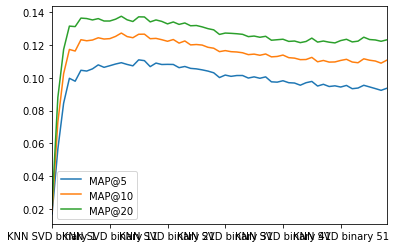

In [411]:
evaluation_results_df.loc[(evaluation_results_df.index.str.contains('SVD') & evaluation_results_df.index.str.contains('binary'))].plot()

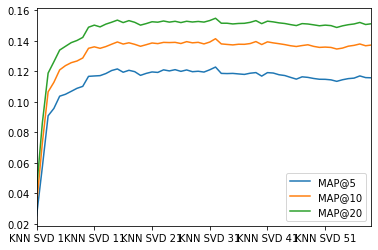

In [412]:
evaluation_results_df.loc[(evaluation_results_df.index.str.contains('SVD')) & (evaluation_results_df.index.str.contains('binary')==False)].plot()